In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [11]:
def flip_image(image): 
    flipped_image = image[::-1]
    return flipped_image

data = pd.read_csv("data/CATSnDOGS.csv")
labels = pd.read_csv("data/labels.csv")

for i in range(len(data)):
    if i%2==0:
        data.iloc[i] = flip_image(data.iloc[i])
    

Some pre-processing, ex find number of PC for kNN ans such

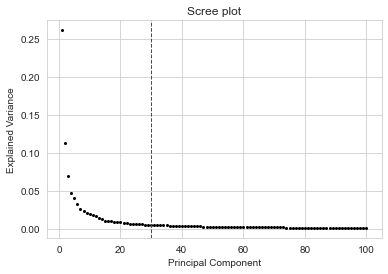

In [12]:
# This should maybe only be done for training data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

trainX_pp = StandardScaler().fit_transform(train_data)
train_data_pca = PCA().fit(trainX_pp)
principal_components_pca = train_data_pca.transform(trainX_pp)

# Plot the importance of the principal components
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

num_components_to_plot = min(100, len(train_data_pca.explained_variance_ratio_))
ax.plot(np.arange(1, num_components_to_plot + 1), train_data_pca.explained_variance_ratio_[:num_components_to_plot], 'ok', markersize=2)
ax.axvline(30, linestyle="dashed", color="red", linewidth=1)
plt.title('Scree plot')
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")
plt.show()

In [13]:
#Top 30 PC looks reasonable 
num_principal_components = 30
num_tests = 50
pca = PCA(n_components=num_principal_components)
scaler = StandardScaler()

#Initialize classifiers
knn_classifier_flexible = KNeighborsClassifier(n_neighbors=3)
knn_classifier_rigid = KNeighborsClassifier(n_neighbors=50)
random_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1)

log_reg = LogisticRegression()
svm_classifier = SVC(kernel='rbf')  # Linear kernel for linear SVM

knn_flexible_scores = []
knn_flexible_correct_dogs = []
knn_flexible_correct_cats = []
knn_flexible_mislabeled_idx = []

knn_rigid_scores = []
knn_rigid_mislabeled_idx = []
knn_rigid_correct_dogs = []
knn_rigid_correct_cats = []

random_forest_scores = []
random_forest_mislabeled_idx = []
random_forest_correct_dogs = []
random_forest_correct_cats = []

log_reg_scores = []
log_reg_mislabeled_idx = []
log_reg_correct_dogs = []
log_reg_correct_cats = []

svm_scores = []
svm_mislabeled_idx = []
svm_correct_dogs = []
svm_correct_cats = []


def get_mislabeled_idx(classifier, test_data, test_labels):
    y_pred = classifier.predict(test_data)
    misclassified_idx = np.where(y_pred != test_labels.to_numpy().squeeze())[0]
    misclassified_idx = test_data.iloc[misclassified_idx].index
    return misclassified_idx

for i in range(num_tests):
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.4)
    
    # Fit the scaler on the training data and transform the training data
    train_data_scaled = scaler.fit_transform(train_data)
    train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_data.columns, index=train_data.index)
    
    # Transform the test data using the already fitted scaler
    test_data_scaled = scaler.transform(test_data)
    test_data_scaled = pd.DataFrame(test_data_scaled, columns=test_data.columns, index=test_data.index)
    
    num_dogs = np.sum(test_labels.values.ravel() == 1)
    num_cats = np.sum(test_labels.values.ravel() == 0)
    
    # Evaluate flexible KNN classifier
    knn_classifier_flexible.fit(train_data_scaled, train_labels.values.ravel())
    predictions = knn_classifier_flexible.predict(test_data_scaled)
    scores_knn_flexible = accuracy_score(test_labels.values.ravel(), predictions)
    knn_flexible_scores.append(scores_knn_flexible)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    knn_flexible_correct_cats.append(correct_cats)
    knn_flexible_correct_dogs.append(correct_dogs)
    
    # Evaluate rigid KNN classifier
    knn_classifier_rigid.fit(train_data_scaled, train_labels.values.ravel())
    knn_classifier_rigid.predict(test_data_scaled)
    predictions = knn_classifier_rigid.predict(test_data_scaled)
    scores_knn_rigid = accuracy_score(test_labels.values.ravel(), predictions)
    knn_rigid_scores.append(scores_knn_rigid)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    knn_rigid_correct_cats.append(correct_cats)
    knn_rigid_correct_dogs.append(correct_dogs)
    
    # Evaluate Random Forest 
    random_forest.fit(train_data, train_labels.values.ravel())
    random_forest.predict(test_data)
    predictions = random_forest.predict(test_data)
    rf_test_accuracy = accuracy_score(test_labels.values.ravel(), predictions)
    random_forest_scores.append(rf_test_accuracy)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    random_forest_correct_cats.append(correct_cats)
    random_forest_correct_dogs.append(correct_dogs)
    

    
    # Evaluate Logistic Regression
    log_reg.fit(train_data, train_labels.values.ravel())
    predictions = log_reg.predict(test_data)
    log_reg_test_accuracy = accuracy_score(test_labels.values.ravel(), predictions)
    log_reg_scores.append(log_reg_test_accuracy)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    log_reg_correct_cats.append(correct_cats)
    log_reg_correct_dogs.append(correct_dogs)
    
    
    # Fit and evaluate the SVM classifier
    svm_classifier.fit(train_data, train_labels.values.ravel())
    predictions = svm_classifier.predict(test_data)
    scores_svm = accuracy_score(test_labels.values.ravel(), predictions)
    svm_scores.append(scores_svm)
    correct_dogs = np.sum(predictions[test_labels.values.ravel() == 1] == 1) / num_dogs
    correct_cats = np.sum(predictions[test_labels.values.ravel() == 0] == 0) / num_cats
    svm_correct_cats.append(correct_cats)
    svm_correct_dogs.append(correct_dogs)
    
    
    
    knn_flexible_mislabeled_idx.append(get_mislabeled_idx(knn_classifier_flexible, test_data_scaled, test_labels))
    knn_rigid_mislabeled_idx.append(get_mislabeled_idx(knn_classifier_rigid, test_data_scaled, test_labels))
    random_forest_mislabeled_idx.append(get_mislabeled_idx(random_forest, test_data, test_labels))
    log_reg_mislabeled_idx.append(get_mislabeled_idx(log_reg, test_data, test_labels))
    svm_mislabeled_idx.append(get_mislabeled_idx(svm_classifier, test_data, test_labels))
    
    

    
print("Test scores for the test set size 40% ")
print('KNN flexible scores:', np.mean(knn_flexible_scores))
print('KNN rigid scores:', np.mean(knn_rigid_scores))
print('Random forest scores:', np.mean(random_forest_scores))
print('Logistic regression scores:', np.mean(log_reg_scores))
print('SVM scores:', np.mean(svm_scores))

C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Test scores for the test set size 40% 
KNN flexible scores: 0.63825
KNN rigid scores: 0.51425
Random forest scores: 0.6285000000000001
Logistic regression scores: 0.6417499999999999
SVM scores: 0.65675


In [14]:

from scipy.stats import f_oneway



f_stat, p_val = f_oneway(knn_flexible_scores, knn_rigid_scores, random_forest_scores, log_reg_scores, svm_scores)
print("ANOVA p-value:", p_val)


ANOVA p-value: 2.23564350034017e-31


Text(0, 0.5, 'Accuracy')

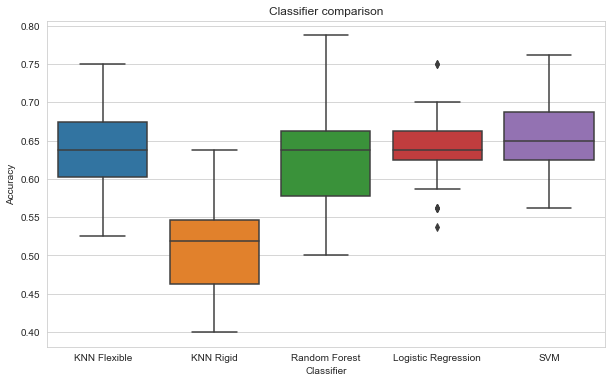

In [15]:
import seaborn as sns

# create boxplots

# Create a dictionary to store the results

results = {
    'KNN Flexible': knn_flexible_scores,
    'KNN Rigid': knn_rigid_scores,
    'Random Forest': random_forest_scores,
    'Logistic Regression': log_reg_scores,
    'SVM': svm_scores
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(results)

# Melt the DataFrame to the long format
df_melt = df.melt(var_name='Classifier', value_name='Accuracy')

# Create a boxplot

plt.figure(figsize=(10, 6))
sns.boxplot(x='Classifier', y='Accuracy', data=df_melt)

plt.title('Classifier comparison')
plt.ylabel('Accuracy')


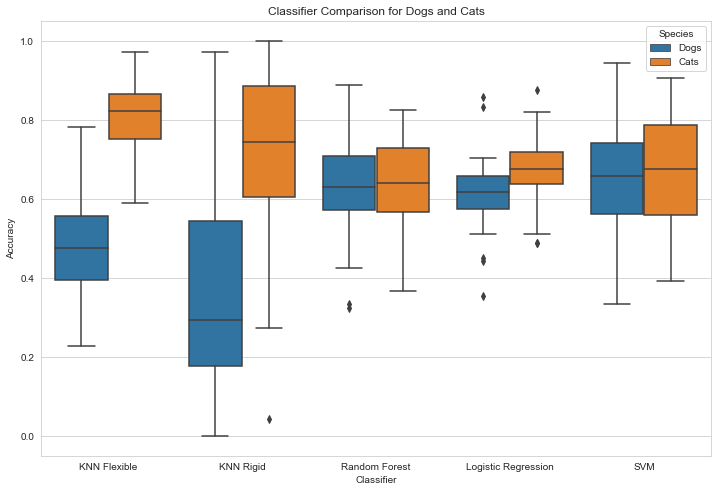

In [16]:
results = {
    'KNN Flexible Dogs': knn_flexible_correct_dogs, 
    'KNN Flexible Cats': knn_flexible_correct_cats,
    'KNN Rigid Dogs': knn_rigid_correct_dogs,
    'KNN Rigid Cats': knn_rigid_correct_cats,
    'Random Forest Dogs': random_forest_correct_dogs,
    'Random Forest Cats': random_forest_correct_cats,
    'Logistic Regression Dogs': log_reg_correct_dogs,
    'Logistic Regression Cats': log_reg_correct_cats,
    'SVM Dogs': svm_correct_dogs,
    'SVM Cats': svm_correct_cats
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(results)

# Melt the DataFrame to long format
df_melt = df.melt(var_name='Classifier_Species', value_name='Accuracy')

# Split the 'Classifier_Species' into 'Classifier' and 'Species'
df_melt[['Classifier', 'Species']] = df_melt['Classifier_Species'].str.rsplit(' ', n=1, expand=True)
df_melt = df_melt.drop(columns=['Classifier_Species'])

# Create a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Classifier', y='Accuracy', hue='Species', data=df_melt)

plt.title('Classifier Comparison for Dogs and Cats')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

In [17]:

from collections import Counter
def get_common_misclassified_idx(mislabeled_idx):
    extended_mislabeled_idx = [item for sublist in mislabeled_idx for item in sublist]
    c = Counter(extended_mislabeled_idx).most_common(10)
    return [item[0] for item in c]

knn_flexible_common_misclassified_idx = get_common_misclassified_idx(knn_flexible_mislabeled_idx)
knn_rigid_common_misclassified_idx = get_common_misclassified_idx(knn_rigid_mislabeled_idx)
random_forest_common_misclassified_idx = get_common_misclassified_idx(random_forest_mislabeled_idx)
log_reg_common_misclassified_idx = get_common_misclassified_idx(log_reg_mislabeled_idx)
svm_common_misclassified_idx = get_common_misclassified_idx(svm_mislabeled_idx)

print("Common misclassified indices:")
print('KNN flexible:', knn_flexible_common_misclassified_idx)
print('KNN rigid:', knn_rigid_common_misclassified_idx)
print('Random forest:', random_forest_common_misclassified_idx)
print('Logistic regression:', log_reg_common_misclassified_idx)
print('SVM:', svm_common_misclassified_idx)


common = set(knn_flexible_common_misclassified_idx) & set(knn_rigid_common_misclassified_idx) & set(random_forest_common_misclassified_idx) & set(log_reg_common_misclassified_idx) & set(svm_common_misclassified_idx)
common = set(knn_flexible_common_misclassified_idx) & set(random_forest_common_misclassified_idx) & set(log_reg_common_misclassified_idx) & set(svm_common_misclassified_idx)

common

Common misclassified indices:
KNN flexible: [88, 41, 185, 112, 98, 143, 154, 78, 31, 102]
KNN rigid: [139, 33, 12, 63, 110, 89, 6, 14, 143, 41]
Random forest: [33, 63, 12, 89, 21, 143, 139, 180, 31, 174]
Logistic regression: [139, 110, 127, 187, 112, 126, 88, 143, 96, 63]
SVM: [63, 33, 139, 12, 143, 89, 31, 41, 180, 117]


{143}

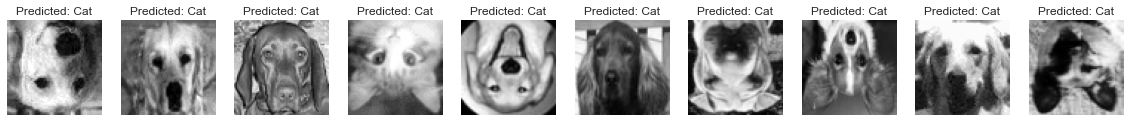

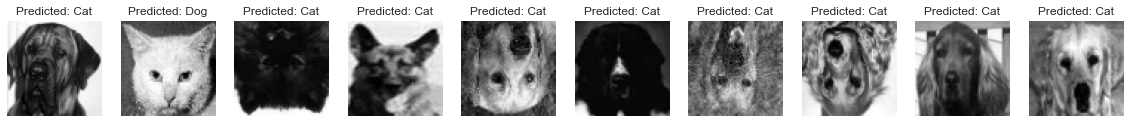

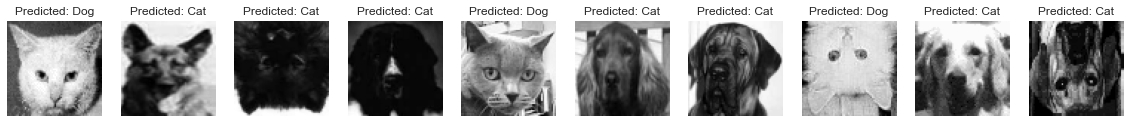

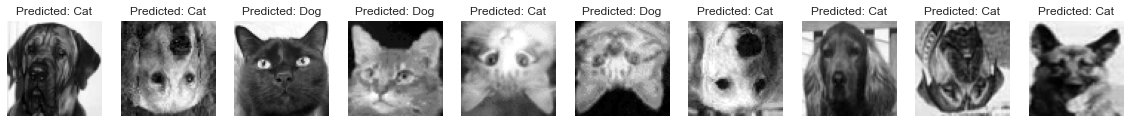

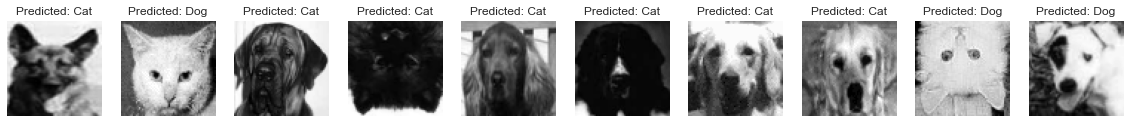

In [18]:
def plot_wrong_images(images_idx):
    labels_map = {0: 'Cat', 1: 'Dog'}
    images = data.iloc[images_idx].values
    fig, axes = plt.subplots(1, len(images_idx), figsize=(20, 20))
    for i, (ax, img) in enumerate(zip(axes, images)):
        true_label = labels.iloc[images_idx[i]].values[0]
        ax.imshow(img.reshape(64, 64).transpose(1, 0), cmap="gray")
        ax.axis('off')
        ax.set_title(f"Predicted: {labels_map[1 - true_label]}")
        
        

plot_wrong_images(knn_flexible_common_misclassified_idx)
plot_wrong_images(knn_rigid_common_misclassified_idx)
plot_wrong_images(random_forest_common_misclassified_idx)
plot_wrong_images(log_reg_common_misclassified_idx)
plot_wrong_images(svm_common_misclassified_idx)

TypeError: 'AxesSubplot' object is not iterable

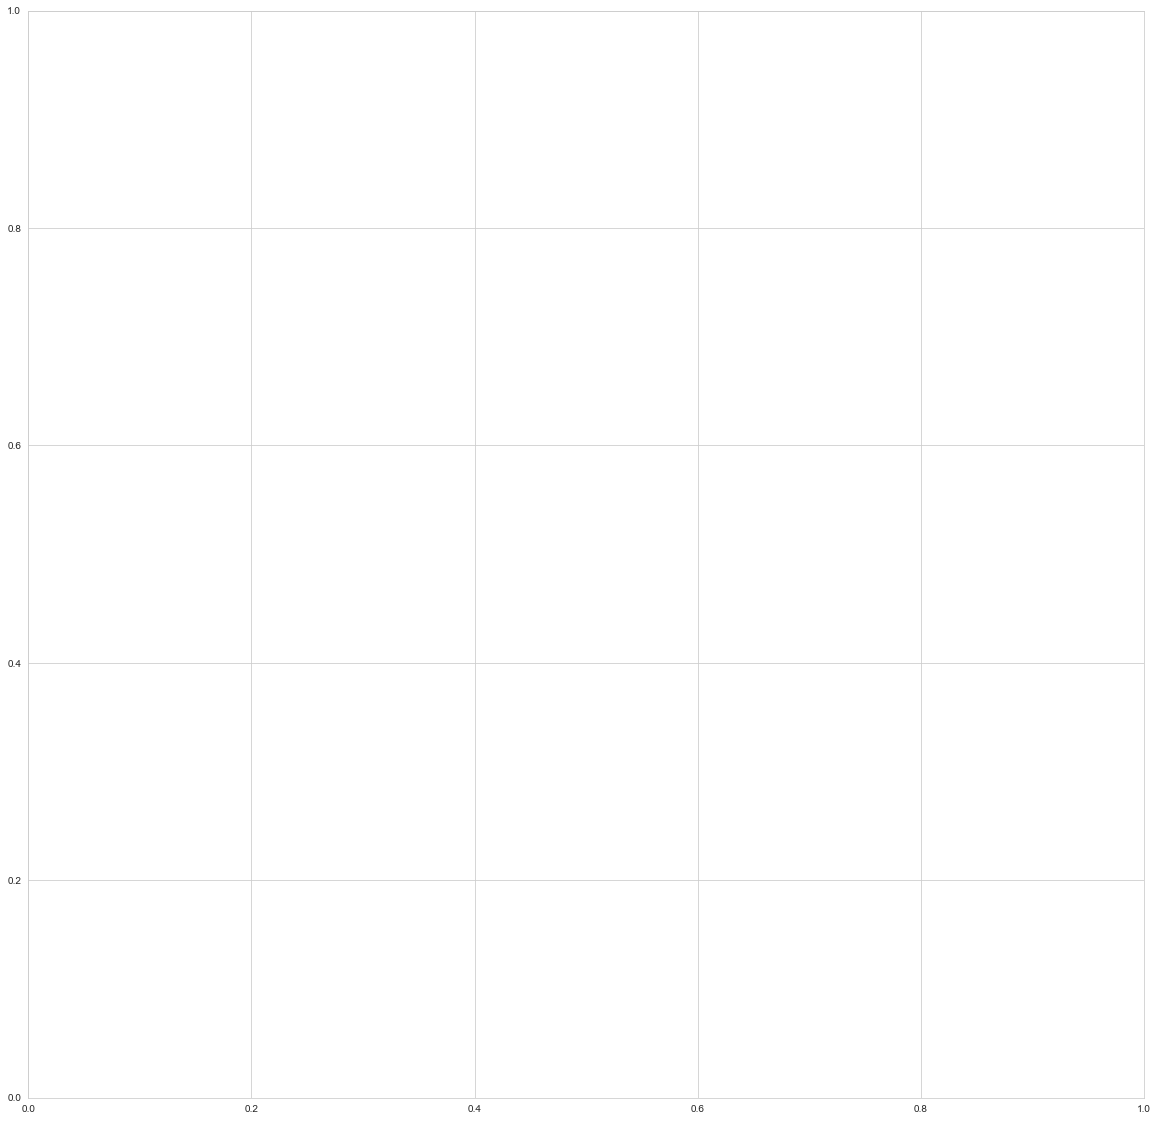

In [19]:
plot_wrong_images(list(common))

In [20]:
labels.iloc[list(common)]

,x
143,1
